<img src="http://www.timzhangyuxuan.com/static/images/project_DCGAN/structure.png" alt="nn" style="width: 800px;"/>

- [GAN Tutorial / NIPS 2016](https://www.youtube.com/watch?v=YpdP_0-IEOw)
- [GAN Tutorial Slides / NIPS 2016](https://arxiv.org/abs/1701.00160)
- [Generative adversarial nets I Goodfellow, J Pouget-Abadie, M Mirza, B Xu, D Warde-Farley, S Ozair, Y. Bengio.](https://arxiv.org/pdf/1406.2661.pdf)
- [This Sem based on part of assignment 3 of cs231n](http://cs231n.github.io/assignments2017/assignment3/)


## MNIST Dataset 

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

Extracting /tmp/mnist\train-images-idx3-ubyte.gz
Extracting /tmp/mnist\train-labels-idx1-ubyte.gz
Extracting /tmp/mnist\t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist\t10k-labels-idx1-ubyte.gz


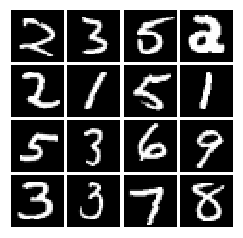

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/mnist', one_hot=False)
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU

In [37]:
def leaky_relu(x, alpha=0.01):
    # implement LeakyReLU
    return tf.maximum(x,alpha*x)

## Random Noise

In [38]:
def sample_noise(batch_size, dim):
    # implement sampling of random noise vector of dim dimension
    return tf.random_uniform(shape=[batch_size,dim],minval=-1,maxval=1,dtype=tf.float32)

----

In [39]:
def discriminator(x):
    with tf.variable_scope("discriminator"):
        fc1 = tf.layers.dense(x, 256, activation=leaky_relu, use_bias=True)
        fc2 = tf.layers.dense(fc1, 256, activation=leaky_relu, use_bias=True)
        logits = tf.layers.dense(fc2, 1, activation=None, use_bias=True)
        return logits

In [40]:
def generator(z):
    with tf.variable_scope("generator"):
        fc1 = tf.layers.dense(z, 1024, activation=tf.nn.relu, use_bias=True)
        fc2 = tf.layers.dense(fc1, 1024, activation=tf.nn.relu, use_bias=True)
        img = tf.layers.dense(fc2, 784, activation=tf.tanh, use_bias=True)
        return img

# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

In [60]:
def gan_loss(logits_real, logits_fake):
    #implement GAN Loss
    D_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_fake, labels = tf.zeros_like(logits_fake))) + \
              tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_real, labels = tf.ones_like(logits_real)) \
                        )
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,labels=tf.ones_like(logits_fake)))
    return D_loss, G_loss

In [61]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    
    return D_solver, G_solver

----

In [62]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
noise_dim = 96

x = tf.placeholder(tf.float32, [None, 784])
# sample noize and generate fake examples
z = sample_noise(batch_size=128,dim=noise_dim)
G_sample = generator(z)

with tf.variable_scope("") as scope:
    # get logits from discriminator for fake and real images
    logits_real = discriminator(preprocess_img(x))
    scope.reuse_variables()
    logits_fake = discriminator(preprocess_img(G_sample))

D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

D_solver, G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)

D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

In [63]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss,
              show_every=250, print_every=50, batch_size=128, num_epoch=10):

    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

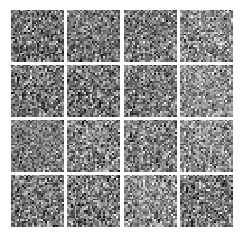


Iter: 0, D: 1.678, G:1.544
Iter: 50, D: 2.441, G:6.12
Iter: 100, D: 1.416, G:2.043
Iter: 150, D: 1.786, G:0.9873
Iter: 200, D: 1.442, G:1.401


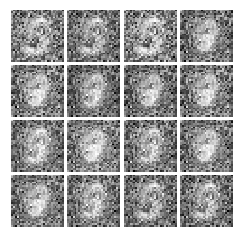


Iter: 250, D: 1.865, G:0.7412
Iter: 300, D: 1.266, G:1.249
Iter: 350, D: 1.576, G:1.416
Iter: 400, D: 1.265, G:1.127
Iter: 450, D: 1.351, G:2.337


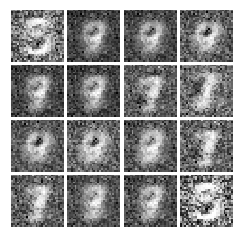


Iter: 500, D: 1.386, G:0.628
Iter: 550, D: 1.4, G:1.519
Iter: 600, D: 1.35, G:0.76
Iter: 650, D: 1.428, G:1.139
Iter: 700, D: 1.203, G:1.163


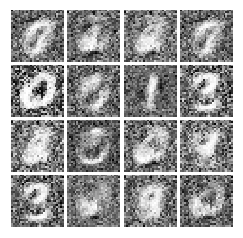


Iter: 750, D: 1.518, G:1.053
Iter: 800, D: 1.383, G:0.8636
Iter: 850, D: 1.267, G:1.243
Iter: 900, D: 1.342, G:1.043
Iter: 950, D: 1.347, G:1.004


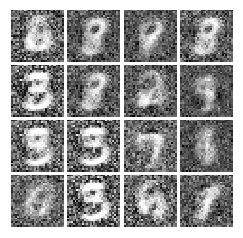


Iter: 1000, D: 1.467, G:0.9217
Iter: 1050, D: 1.459, G:0.8934
Iter: 1100, D: 1.295, G:0.9426
Iter: 1150, D: 1.376, G:0.8113
Iter: 1200, D: 1.307, G:0.8998


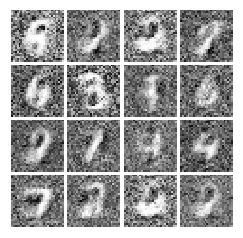


Iter: 1250, D: 1.321, G:0.9381
Iter: 1300, D: 1.394, G:0.9364
Iter: 1350, D: 1.378, G:0.7819
Iter: 1400, D: 1.441, G:0.822
Iter: 1450, D: 1.319, G:0.8606


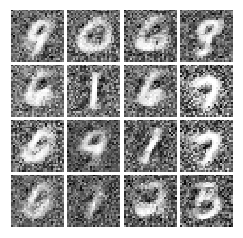


Iter: 1500, D: 1.365, G:0.9293
Iter: 1550, D: 1.391, G:0.8277
Iter: 1600, D: 1.402, G:0.9071
Iter: 1650, D: 1.378, G:0.9202
Iter: 1700, D: 1.286, G:0.7393


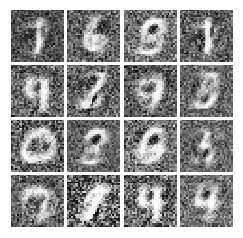


Iter: 1750, D: 1.274, G:0.8524
Iter: 1800, D: 1.331, G:0.7778
Iter: 1850, D: 1.3, G:0.8653
Iter: 1900, D: 1.3, G:0.8685
Iter: 1950, D: 1.316, G:0.8582


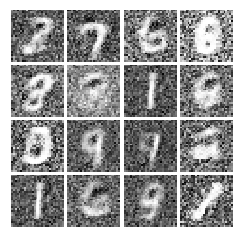


Iter: 2000, D: 1.346, G:0.8085
Iter: 2050, D: 1.37, G:0.8588
Iter: 2100, D: 1.388, G:0.9134
Iter: 2150, D: 1.35, G:0.9109
Iter: 2200, D: 1.362, G:0.8484


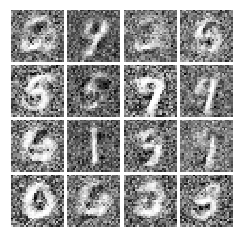


Iter: 2250, D: 1.341, G:0.8591
Iter: 2300, D: 1.314, G:0.864
Iter: 2350, D: 1.383, G:0.8234
Iter: 2400, D: 1.486, G:0.7999
Iter: 2450, D: 1.363, G:0.7738


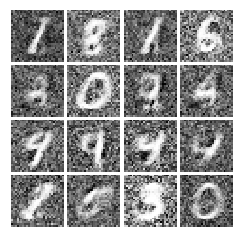


Iter: 2500, D: 1.307, G:0.8343
Iter: 2550, D: 1.32, G:0.7927
Iter: 2600, D: 1.311, G:0.8023
Iter: 2650, D: 1.306, G:0.8314
Iter: 2700, D: 1.322, G:0.8779


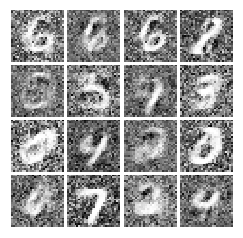


Iter: 2750, D: 1.371, G:0.7982
Iter: 2800, D: 1.386, G:0.7437
Iter: 2850, D: 1.333, G:0.8256
Iter: 2900, D: 1.344, G:0.8176
Iter: 2950, D: 1.29, G:0.8371


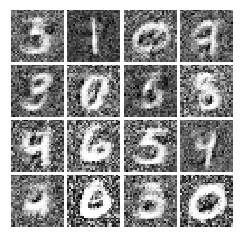


Iter: 3000, D: 1.27, G:0.815
Iter: 3050, D: 1.305, G:0.8358
Iter: 3100, D: 1.346, G:0.8068
Iter: 3150, D: 1.338, G:0.8419
Iter: 3200, D: 1.33, G:0.9527


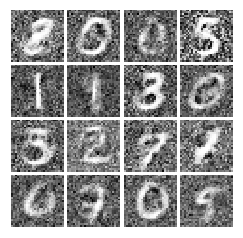


Iter: 3250, D: 1.34, G:0.8807
Iter: 3300, D: 1.303, G:0.8776
Iter: 3350, D: 1.292, G:0.8142
Iter: 3400, D: 1.343, G:0.8211
Iter: 3450, D: 1.315, G:0.8766


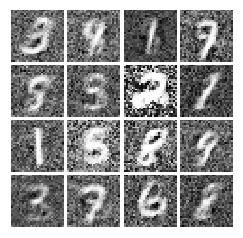


Iter: 3500, D: 1.284, G:0.8678
Iter: 3550, D: 1.313, G:0.9514
Iter: 3600, D: 1.343, G:0.8364
Iter: 3650, D: 1.327, G:0.8165
Iter: 3700, D: 1.302, G:0.8378


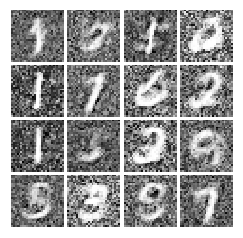


Iter: 3750, D: 1.263, G:0.905
Iter: 3800, D: 1.278, G:0.8551
Iter: 3850, D: 1.335, G:0.8904
Iter: 3900, D: 1.245, G:0.8955
Iter: 3950, D: 1.282, G:0.9091


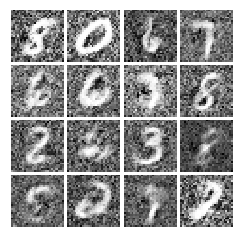


Iter: 4000, D: 1.298, G:0.9463
Iter: 4050, D: 1.323, G:0.9838
Iter: 4100, D: 1.41, G:1.137
Iter: 4150, D: 1.347, G:0.7895
Iter: 4200, D: 1.295, G:0.9345


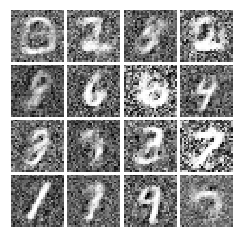


Iter: 4250, D: 1.215, G:1.02
Final images


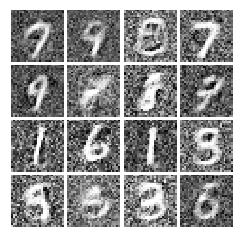

In [64]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss)

# Least Squares GAN
[Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


In [65]:
def lsgan_loss(score_real, score_fake):
    # implement LS GAN Loss
    D_loss = 1./2*tf.reduce_mean(tf.square(score_real - tf.ones_like(score_real))) + 1./2*tf.reduce_mean(tf.square(score_fake))
    G_loss = 1./2*tf.reduce_mean(tf.square(score_fake - tf.ones_like(score_fake)))
    return D_loss, G_loss

In [66]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

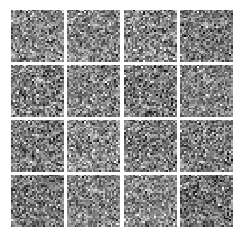


Iter: 0, D: 0.7749, G:12.91
Iter: 50, D: 0.2101, G:1.448
Iter: 100, D: 0.445, G:0.7826
Iter: 150, D: 0.1099, G:0.6222
Iter: 200, D: 0.1456, G:0.6495


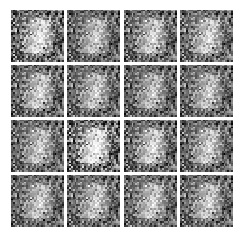


Iter: 250, D: 0.2432, G:0.5073
Iter: 300, D: 0.1968, G:0.3781
Iter: 350, D: 0.1214, G:0.2371
Iter: 400, D: 0.2001, G:0.4634
Iter: 450, D: 0.2601, G:0.3298


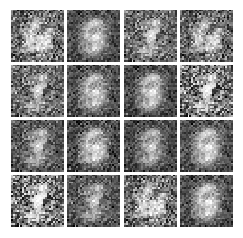


Iter: 500, D: 0.1623, G:0.502
Iter: 550, D: 0.1631, G:0.5138
Iter: 600, D: 0.1899, G:0.6153
Iter: 650, D: 0.3043, G:0.9289
Iter: 700, D: 0.2489, G:0.4252


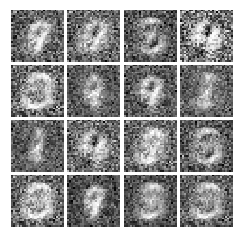


Iter: 750, D: 0.1639, G:0.3596
Iter: 800, D: 0.197, G:0.2539
Iter: 850, D: 0.2531, G:0.3376
Iter: 900, D: 0.2152, G:0.3729
Iter: 950, D: 0.2101, G:0.2808


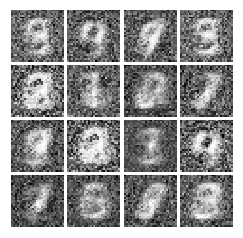


Iter: 1000, D: 0.2449, G:0.2433
Iter: 1050, D: 0.2181, G:0.3123
Iter: 1100, D: 0.2276, G:0.245
Iter: 1150, D: 0.2438, G:0.1991
Iter: 1200, D: 0.2464, G:0.2177


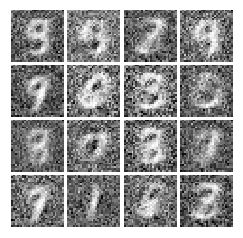


Iter: 1250, D: 0.2242, G:0.1911
Iter: 1300, D: 0.2663, G:0.1751
Iter: 1350, D: 0.2322, G:0.1727
Iter: 1400, D: 0.2346, G:0.155
Iter: 1450, D: 0.2347, G:0.1972


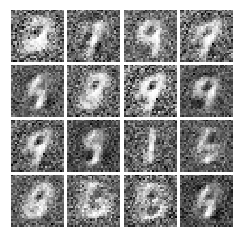


Iter: 1500, D: 0.2459, G:0.1668
Iter: 1550, D: 0.2385, G:0.1568
Iter: 1600, D: 0.2519, G:0.158
Iter: 1650, D: 0.2448, G:0.1568
Iter: 1700, D: 0.2552, G:0.1791


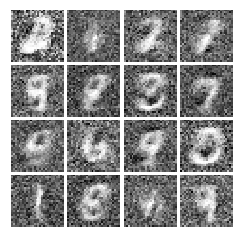


Iter: 1750, D: 0.247, G:0.1711
Iter: 1800, D: 0.2371, G:0.1902
Iter: 1850, D: 0.2477, G:0.2129
Iter: 1900, D: 0.2321, G:0.1821
Iter: 1950, D: 0.2506, G:0.179


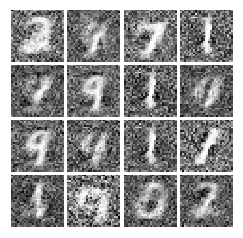


Iter: 2000, D: 0.2394, G:0.1895
Iter: 2050, D: 0.2434, G:0.1966
Iter: 2100, D: 0.2337, G:0.1869
Iter: 2150, D: 0.249, G:0.1734
Iter: 2200, D: 0.2382, G:0.1605


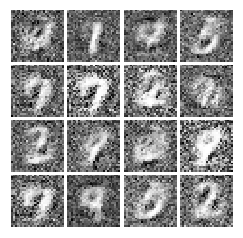


Iter: 2250, D: 0.2373, G:0.1659
Iter: 2300, D: 0.2302, G:0.1797
Iter: 2350, D: 0.2112, G:0.1689
Iter: 2400, D: 0.2056, G:0.1677
Iter: 2450, D: 0.2305, G:0.2007


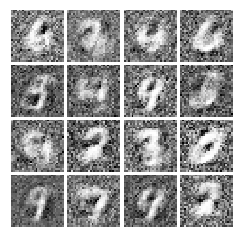


Iter: 2500, D: 0.2439, G:0.1827
Iter: 2550, D: 0.2231, G:0.1765
Iter: 2600, D: 0.2367, G:0.1789
Iter: 2650, D: 0.2227, G:0.1706
Iter: 2700, D: 0.223, G:0.1853


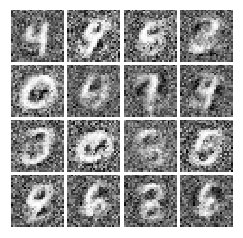


Iter: 2750, D: 0.2558, G:0.1539
Iter: 2800, D: 0.2084, G:0.2249
Iter: 2850, D: 0.2281, G:0.1805
Iter: 2900, D: 0.2046, G:0.1754
Iter: 2950, D: 0.2414, G:0.1948


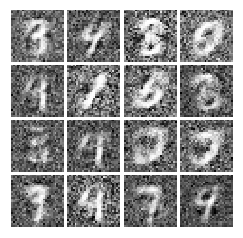


Iter: 3000, D: 0.2284, G:0.239
Iter: 3050, D: 0.2193, G:0.1978
Iter: 3100, D: 0.2179, G:0.1998
Iter: 3150, D: 0.2196, G:0.1924
Iter: 3200, D: 0.2258, G:0.2161


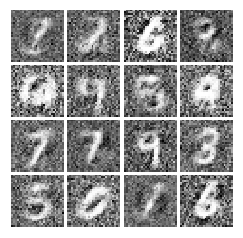


Iter: 3250, D: 0.2303, G:0.1815
Iter: 3300, D: 0.2392, G:0.1777
Iter: 3350, D: 0.2457, G:0.1739
Iter: 3400, D: 0.2512, G:0.1819
Iter: 3450, D: 0.2159, G:0.1858


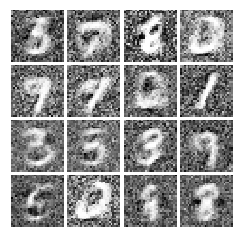


Iter: 3500, D: 0.233, G:0.18
Iter: 3550, D: 0.2242, G:0.166
Iter: 3600, D: 0.2243, G:0.1806
Iter: 3650, D: 0.2434, G:0.1859
Iter: 3700, D: 0.2548, G:0.1915


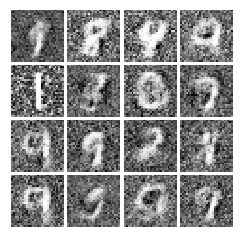


Iter: 3750, D: 0.2501, G:0.1785
Iter: 3800, D: 0.24, G:0.1605
Iter: 3850, D: 0.2327, G:0.1705
Iter: 3900, D: 0.2373, G:0.1798
Iter: 3950, D: 0.2041, G:0.2262


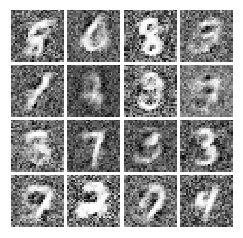


Iter: 4000, D: 0.2326, G:0.2048
Iter: 4050, D: 0.2411, G:0.1889
Iter: 4100, D: 0.2354, G:0.1871
Iter: 4150, D: 0.2124, G:0.204
Iter: 4200, D: 0.218, G:0.2177


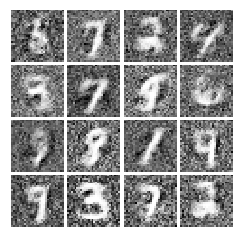


Iter: 4250, D: 0.2376, G:0.1854
Final images


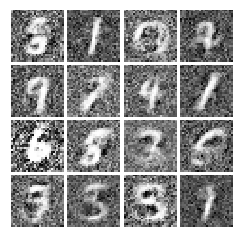

In [67]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss)

## Deep Convolutional GANs

In [68]:
def discriminator(x):
    with tf.variable_scope("discriminator"):
        shape = tf.shape(x);
        images = tf.reshape(x, [shape[0], 28, 28, 1])
        
        conv1 = tf.layers.conv2d(images, filters=32, kernel_size=(5, 5),
                                 activation=leaky_relu, use_bias=True);
        
        pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID");
        
        conv2 = tf.layers.conv2d(pool1, filters=64, kernel_size=(5, 5),
                                 activation=leaky_relu, use_bias=True);
        
        pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID");
        
        flatten = tf.contrib.layers.flatten(pool2);
        dense1 = tf.layers.dense(flatten, 16*64, activation=leaky_relu, use_bias=True);
        
        logits = tf.layers.dense(dense1, 1, activation=None, use_bias=True);
        return logits

In [69]:
def generator(z):
    with tf.variable_scope("generator"):
        dense1 = tf.layers.dense(inputs=z, units=1024, activation=tf.nn.relu)
        batchnorm1 = tf.layers.batch_normalization(inputs=dense1)

        dense2 = tf.layers.dense(inputs=batchnorm1, units=6272, activation=tf.nn.relu)
        batchnorm2 = tf.layers.batch_normalization(inputs=dense2)

        images = tf.reshape(batchnorm2, [-1, 7, 7, 128])

        conv1 = tf.layers.conv2d_transpose(inputs=images, filters=64, kernel_size=[4, 4], 
                                           strides=2, padding='SAME', activation=tf.nn.relu)
        batchnorm3 = tf.layers.batch_normalization(inputs=conv1)

        conv2 = tf.layers.conv2d_transpose(inputs=batchnorm3, filters=1, kernel_size=[4, 4],
                                           strides=2, padding='SAME', activation=tf.tanh)

        img = tf.reshape(conv2, [-1, 28 * 28])
        return img

In [70]:
tf.reset_default_graph()

batch_size = 128
noise_dim = 96

x = tf.placeholder(tf.float32, [None, 784])
# sample noize and generate fake examples
z = sample_noise(batch_size=128,dim=noise_dim)
G_sample = generator(z)

with tf.variable_scope("") as scope:
    # get logits from discriminator for fake and real images
    logits_real = discriminator(preprocess_img(x))
    scope.reuse_variables()
    logits_fake = discriminator(preprocess_img(G_sample))
    
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)

D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

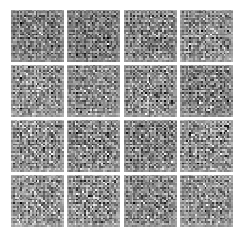


Iter: 0, D: 1.376, G:0.6023
Iter: 50, D: 0.6108, G:2.207


KeyboardInterrupt: 

In [71]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,num_epoch=5)